In [1]:
# @title Imports

from google.colab import drive
drive.mount('/content/gdrive')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# !pip install torch torchvision
import torch
import torchvision

# !pip install onnx onnxruntime
import onnx
import onnxruntime

import copy
import math
import cv2
# !pip install albumentations
import albumentations as A
import random
import time
import datetime

# !pip install pillow
from torchvision.ops import box_iou
from pycocotools.coco import COCO
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
from PIL import Image
from collections import defaultdict, deque
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.8 MB/s eta 0:00:00


In [2]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [3]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform= None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [4]:
dataset_path = "/content/gdrive/MyDrive/Aquarium Combined"
## Assuming that the dataset is in the home directory inside the google drive. Change this path according to the location where this dataset is saved.

In [5]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=4.80s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [6]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
# Loading the Train and Validation dataset in a format suitable for scipting.
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dataset = AquariumDetection(root=dataset_path, split="valid", transforms=get_transforms(False))
val_data_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=1.90s)
creating index...
index created!


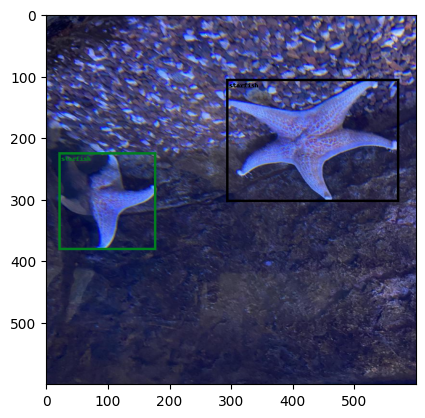

In [9]:
sample = train_dataset[5]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4).permute(1, 2, 0))

In [10]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 151MB/s]


In [11]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
model = model.to(device)

In [14]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [15]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [16]:
num_epochs=8

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [01:07<00:00,  1.66it/s]


Epoch 0, lr: 0.010000, loss: 0.975746, loss_classifier: 0.455778, loss_box: 0.394138, loss_rpn_box: 0.032362, loss_object: 0.093469


100%|██████████| 112/112 [00:31<00:00,  3.53it/s]


Epoch 1, lr: 0.010000, loss: 0.769982, loss_classifier: 0.333649, loss_box: 0.347418, loss_rpn_box: 0.029035, loss_object: 0.059880


100%|██████████| 112/112 [00:22<00:00,  5.08it/s]


Epoch 2, lr: 0.010000, loss: 0.731607, loss_classifier: 0.305732, loss_box: 0.352810, loss_rpn_box: 0.027188, loss_object: 0.045876


100%|██████████| 112/112 [00:25<00:00,  4.37it/s]


Epoch 3, lr: 0.010000, loss: 0.683911, loss_classifier: 0.272550, loss_box: 0.347038, loss_rpn_box: 0.024954, loss_object: 0.039370


100%|██████████| 112/112 [00:20<00:00,  5.39it/s]


Epoch 4, lr: 0.010000, loss: 0.676410, loss_classifier: 0.269746, loss_box: 0.348368, loss_rpn_box: 0.023428, loss_object: 0.034868


100%|██████████| 112/112 [00:21<00:00,  5.16it/s]


Epoch 5, lr: 0.010000, loss: 0.671891, loss_classifier: 0.257305, loss_box: 0.357401, loss_rpn_box: 0.023193, loss_object: 0.033992


100%|██████████| 112/112 [00:22<00:00,  4.91it/s]


Epoch 6, lr: 0.010000, loss: 0.634770, loss_classifier: 0.236306, loss_box: 0.347722, loss_rpn_box: 0.022249, loss_object: 0.028492


100%|██████████| 112/112 [00:21<00:00,  5.24it/s]

Epoch 7, lr: 0.010000, loss: 0.629731, loss_classifier: 0.231199, loss_box: 0.349917, loss_rpn_box: 0.021881, loss_object: 0.026733


In [17]:
# @title Evaluation metrics(mAP)
# calculate mean Average Precision (mAP) across all IoU thresholds
def calculate_mAP(pred_boxes_list, pred_labels_list, pred_scores_list, true_boxes_list, true_labels_list):
    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    mAP = []

    for iou_threshold in iou_thresholds:
        TP = 0
        FP = 0
        FN = 0

        for pred_boxes, pred_labels, pred_scores, true_boxes, true_labels in zip(
            pred_boxes_list, pred_labels_list, pred_scores_list, true_boxes_list, true_labels_list):

            pred_boxes = torch.tensor(pred_boxes).reshape(-1, 4)
            true_boxes = torch.tensor(true_boxes).reshape(-1, 4)

            iou = box_iou(pred_boxes, true_boxes)

            for i in range(len(pred_boxes)):
                match = (iou[i] > iou_threshold) & (pred_labels[i] == true_labels)
                if match.any():
                    TP += 1
                else:
                    FP += 1

        FN = len(true_boxes) - TP #false negatives

        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0

        AP = 0.5 * (precision + recall) #average precision (AP)
        mAP.append(AP)

    mAP = sum(mAP) / len(mAP)
    return mAP

# to extract bounding boxes, labels, and scores from the model's output
def process_output(output):

    pred_boxes = output['boxes']
    pred_labels = output['labels']
    pred_scores = output['scores']
    return pred_boxes, pred_labels, pred_scores

# to evaluate the model with ground truth to give mean average precision
def evaluate_model(model, data_loader, device):
    model = model.to(device)
    model.eval()
    pred_boxes_list, pred_labels_list, pred_scores_list = [], [], []
    true_boxes_list, true_labels_list = [], []

    with torch.no_grad():
        for images, targets in data_loader:

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            images_tensor = torch.stack(images, dim=0)

            outputs = model(images_tensor)

            # Extract predictions
            pred_boxes = [output['boxes'].cpu().numpy() for output in outputs]
            pred_labels = [output['labels'].cpu().numpy() for output in outputs]
            pred_scores = [output['scores'].cpu().numpy() for output in outputs]

            # Extract ground truth
            true_boxes = [target['boxes'].cpu().numpy() for target in targets]
            true_labels = [target['labels'].cpu().numpy() for target in targets]

            # append the bb to lists
            pred_boxes_list.extend(pred_boxes)
            pred_labels_list.extend(pred_labels)
            pred_scores_list.extend(pred_scores)
            true_boxes_list.extend(true_boxes)
            true_labels_list.extend(true_labels)

    mean_ap = calculate_mAP(pred_boxes_list, pred_labels_list, pred_scores_list, true_boxes_list, true_labels_list)

    return mean_ap

In [18]:
# Test Dataset
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

random_index = random.randint(0, len(test_dataset) - 1)  # get a random input each time the code is ran
img, _ = test_dataset[random_index]
img_int = torch.tensor(img * 255, dtype=torch.uint8)

model.eval()  # set the model to evaluation mode to check for inference
model = model.to(device)

start_time = time.time()
with torch.no_grad():
    prediction = model([img.to(device)])
end_time = time.time()

original_inference_time = end_time - start_time
print("\nOriginal Model Inference time: {:.6f} seconds".format(original_inference_time))


loading annotations into memory...
Done (t=1.16s)
creating index...
index created!

Original Model Inference time: 0.143991 seconds


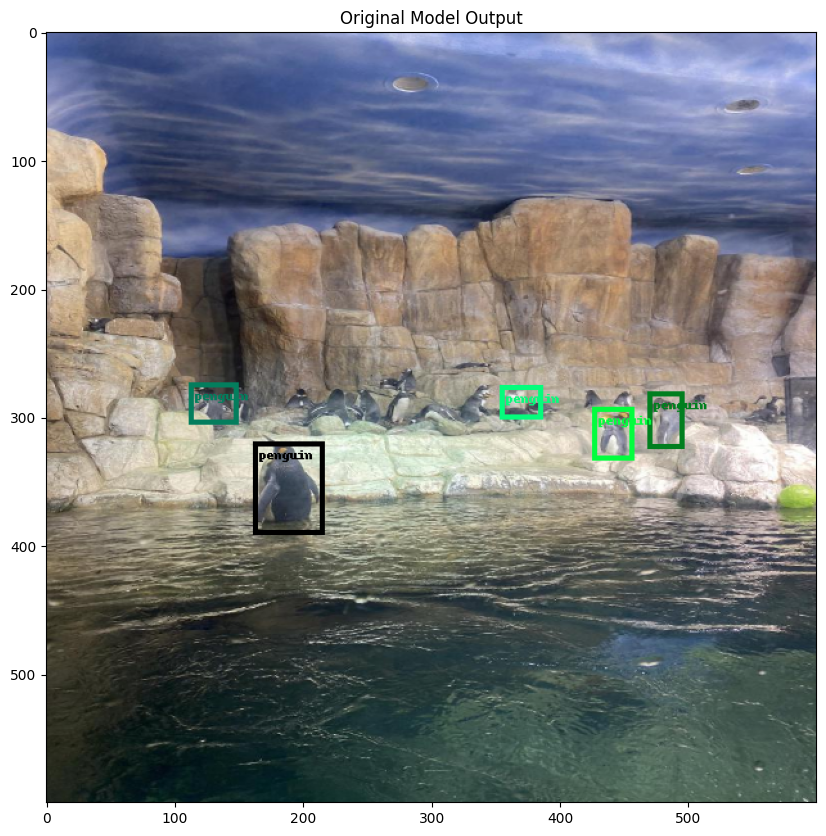

In [19]:
# Extract and Process Outputs
pred = prediction[0]
pred_boxes = pred['boxes']
pred_labels = pred['labels']
pred_scores = pred['scores']

# Visualize the Output
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(
    img_int,
    pred_boxes[pred_scores > 0.6],
    [classes[i] for i in pred_labels[pred_scores > 0.6].tolist()], width=4
).permute(1, 2, 0))
plt.title("Original Model Output")
plt.show()

In [20]:
# Evaluate Original Model
original_mAP = evaluate_model(model, val_data_loader, device)
print("Original Model mAP:", original_mAP)

Original Model mAP: 36.69207547169812




# TorchScript Optimization

In [21]:
# @title Wrapper Classes(TorchScript)
# torchscript wrapper to do the inference optimization for one image.
class TorchScriptWrapper(nn.Module):
    def __init__(self, model):
        super(TorchScriptWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Remove batch dimension before passing to the model
        x = x.squeeze(0)
        output = self.model([x])
        return output

#this class is for mapping the bounding boxes and checking their accuracies with the actual ones.
class mAPTorchScriptModel(nn.Module):
    def __init__(self, scripted_model):
        super().__init__()
        self.scripted_model = scripted_model

    def forward(self, images, targets=None):
        # Initialize lists to store outputs
        batched_outputs = []
        for img in images:
            # Add an extra batch dimension
            img = img.unsqueeze(0)
            # Get the output for the current image
            output = self.scripted_model(img)
            # Append the output to the list
            batched_outputs.append(output[1][0])
        return batched_outputs

In [22]:
# TorchScripting the Model
model = model.to('cpu')
torch_model = TorchScriptWrapper(model)
torch_model.eval()
scripted_model = torch.jit.script(torch_model)
mAP_scripted_model = mAPTorchScriptModel(scripted_model).to(device)

# Save and Load Scripted Model
model_path = "faster_rcnn.script"
torch.jit.save(scripted_model, model_path)
scripted_model = torch.jit.load(model_path)

# Test the Scripted Model and measure speed
def measure_speed_torchscript(scripted_model, sample_input):
    scripted_model = scripted_model.to(device)
    sample_input = sample_input.to(device)
    start_time = time.time()
    outputs = scripted_model(sample_input)
    end_time = time.time()

    inference_time = end_time - start_time
    print("TorchScript Model Inference time: {:.6f} seconds".format(inference_time))
    return outputs, inference_time

outputs_ts, torchscript_inference_time = measure_speed_torchscript(scripted_model, img)


TorchScript Model Inference time: 0.722427 seconds


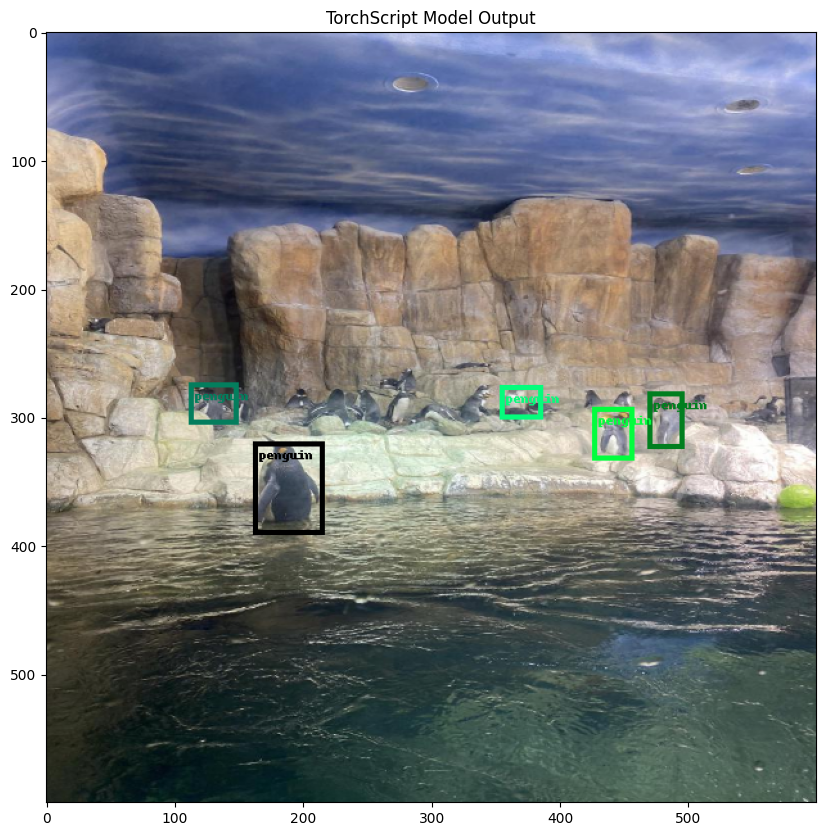

In [23]:
# Visualize the Output of TorchScript Model
pred_boxes_ts = outputs_ts[1][0]['boxes']
pred_labels_ts = outputs_ts[1][0]['labels']
pred_scores_ts = outputs_ts[1][0]['scores']


fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(
    img_int,
    pred_boxes_ts[pred_scores_ts > 0.6],
    [classes[i] for i in pred_labels_ts[pred_scores_ts > 0.6].tolist()], width=4
).permute(1, 2, 0))
plt.title("TorchScript Model Output")
plt.show()

In [24]:
# Evaluate the TorchScript Optimized model
torchscript_mAP = evaluate_model(mAP_scripted_model, val_data_loader, device)
print("TorchScript Model mAP:", torchscript_mAP)

TorchScript Model mAP: 36.69207547169812


# ONNX Optimization

In [25]:
# @title Wrapper Classes(ONNX)
# onnx wrapper to do the inference optimization for one image.
class ONNXWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, images):
        if not isinstance(images, list):
            images = [images]
        targets = None
        return self.model(images, targets)


#this class is for mapping the bounding boxes and checking their accuracies with the actual ones.
class mAPONNXWrapper(nn.Module):
    def __init__(self, onnx_model):
        super().__init__()
        self.onnx_model = onnx_model

    def forward(self, images, targets=None):
        # Initialize lists to store outputs
        batched_outputs = []
        for img in images:
            # Get the output for the current image
            output = self.onnx_model(img)
            # Append the output to the list
            batched_outputs.append(output[0])
        return batched_outputs

In [26]:
# wrap the original model
onnx_model = ONNXWrapper(model)

mAP_onnx_model = mAPONNXWrapper(onnx_model).to(device)
onnx_model = onnx_model.to('cpu')

## perform inference and measure time
start_time = time.time()
with torch.no_grad():
    outputs_onnx = onnx_model(img)
end_time = time.time()

onnx_inference_time = end_time - start_time
print("ONNX Model Inference time: {:.6f} seconds".format(onnx_inference_time))

ONNX Model Inference time: 0.729872 seconds


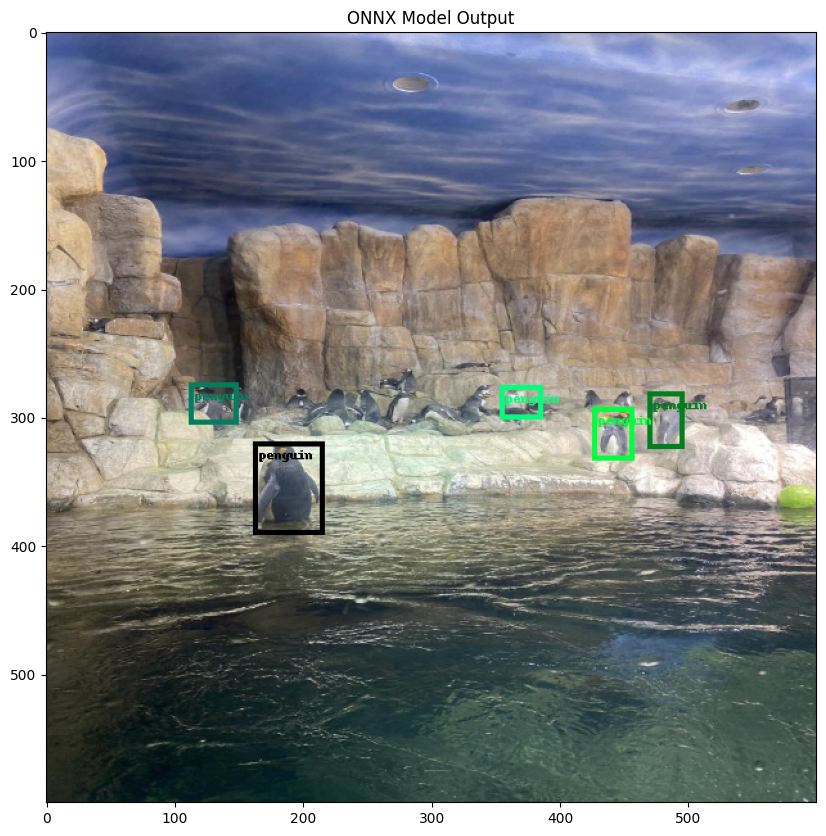

In [27]:
# Visualize the Output of ONNX Model
pred_boxes_onnx = outputs_onnx[0]['boxes']
pred_labels_onnx = outputs_onnx[0]['labels']
pred_scores_onnx = outputs_onnx[0]['scores']


fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(
    img_int,
    pred_boxes_onnx[pred_scores_onnx > 0.6],
    [classes[int(i)] for i in pred_labels_onnx[pred_scores_onnx > 0.6].tolist()],
    width=4
).permute(1, 2, 0))
plt.title("ONNX Model Output")
plt.show()

In [28]:
# Evaluate the ONNX optimized model
onnx_mAP = evaluate_model(mAP_onnx_model, val_data_loader, device)
print("ONNX Model mAP:", onnx_mAP)

ONNX Model mAP: 36.69207547169812


# Bar plots to compare the models

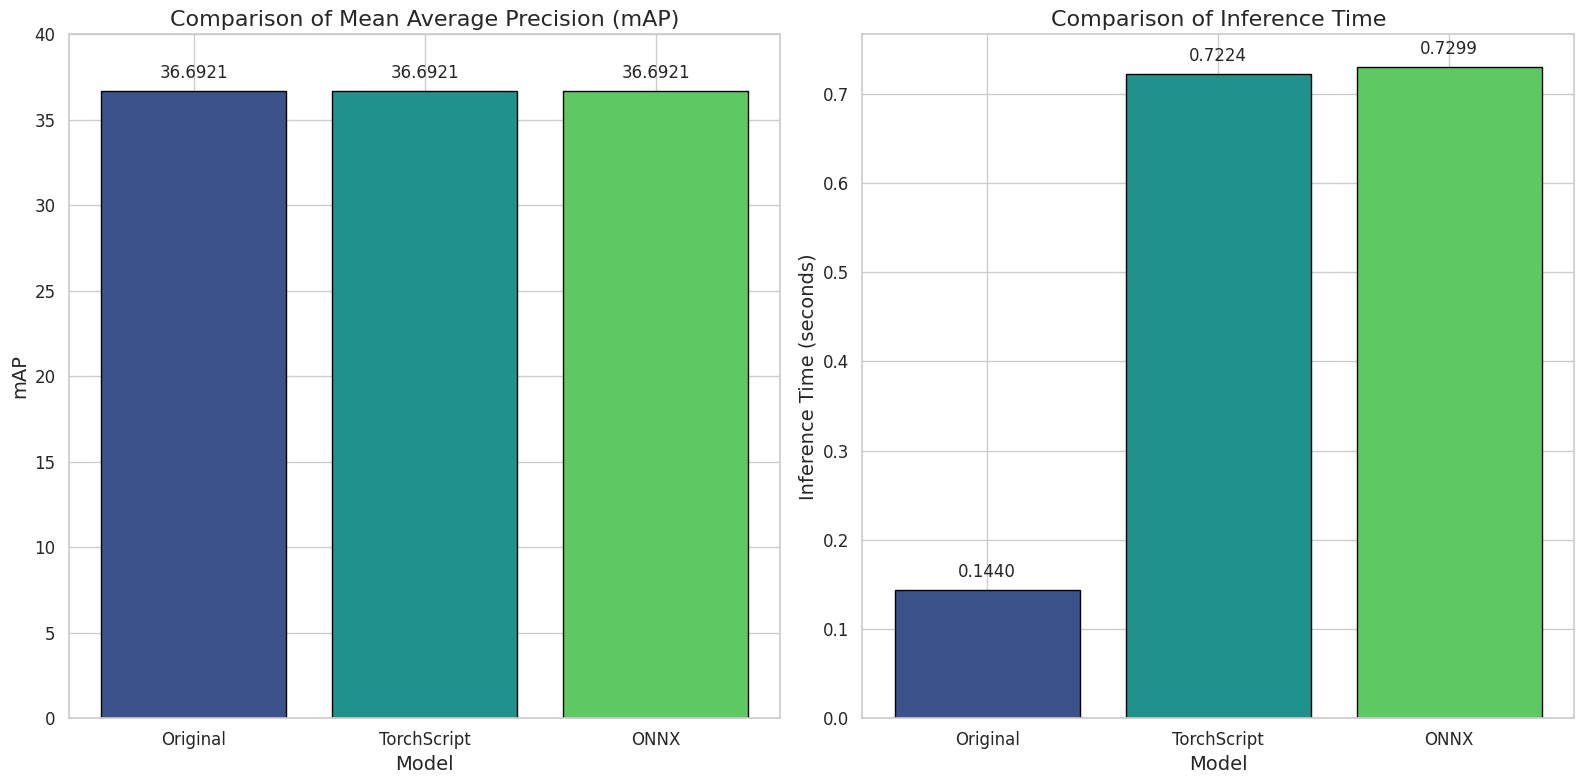

In [29]:
models = ['Original', 'TorchScript', 'ONNX']
mAP_values = [original_mAP, torchscript_mAP, onnx_mAP]  # Replace with actual values
inference_times = [original_inference_time, torchscript_inference_time, onnx_inference_time]  # Replace with actual values

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# mAP plot
axes[0].bar(models, mAP_values, color=sns.color_palette("viridis", len(models)), edgecolor='black')
axes[0].set_title('Comparison of Mean Average Precision (mAP)', fontsize=16)
axes[0].set_xlabel('Model', fontsize=14)
axes[0].set_ylabel('mAP', fontsize=14)
axes[0].set_ylim([0, 40])
axes[0].tick_params(labelsize=12)
for i, val in enumerate(mAP_values):
    axes[0].text(i, val + 0.5, f"{val:.4f}", ha='center', va='bottom', fontsize=12)

# Inference time plot
axes[1].bar(models, inference_times, color=sns.color_palette("viridis", len(models)), edgecolor='black')
axes[1].set_title('Comparison of Inference Time', fontsize=16)
axes[1].set_xlabel('Model', fontsize=14)
axes[1].set_ylabel('Inference Time (seconds)', fontsize=14)
axes[1].tick_params(labelsize=12)
for i, val in enumerate(inference_times):
    axes[1].text(i, val + 0.01, f"{val:.4f}", ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()